<a href="https://colab.research.google.com/github/rajanaids-hub/Reinforcement_Learning_Lab/blob/main/Monte_Carlo_Blackjack_EXP5_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

♠️ ♥️ Creating Blackjack Environment... ♦️ ♣️
🧠 Training Monte Carlo Agent by playing 500,000 hands of Blackjack...
   (This takes a few seconds because it has to simulate every single game!)
   Played 100,000 hands... (Epsilon: 0.368)
   Played 200,000 hands... (Epsilon: 0.135)
   Played 300,000 hands... (Epsilon: 0.100)
   Played 400,000 hands... (Epsilon: 0.100)
   Played 500,000 hands... (Epsilon: 0.100)

✅ Training Complete! Generating Strategy Charts...


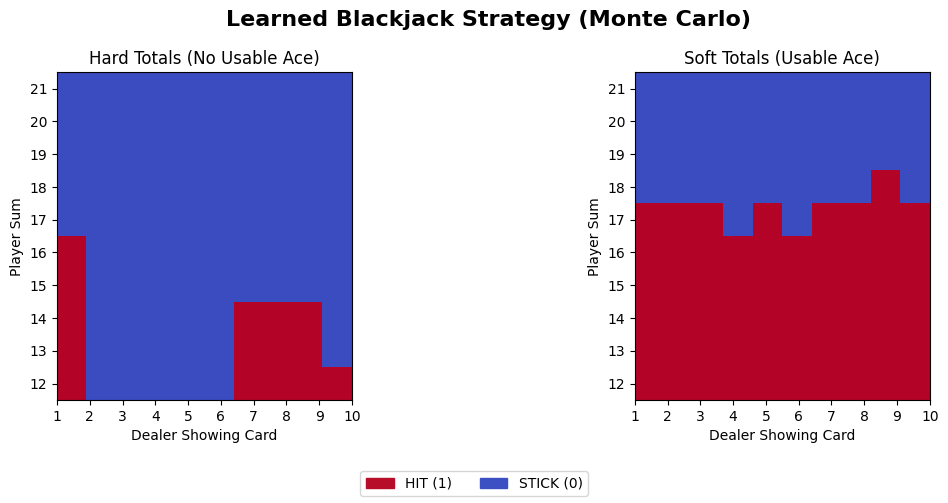

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gymnasium as gym

# =====================================================================
# 🎓 STUDENT EXPERIMENT SETTINGS: MONTE CARLO 🎓
# =====================================================================
# Monte Carlo requires a LOT of episodes because it only updates at the
# very end of a game. Half a million games is standard for Blackjack!
EPISODES = 500_000
GAMMA = 1.0             # Discount factor (No discount for Blackjack)
EPSILON_START = 1.0     # Start by exploring 100% of the time
EPSILON_DECAY = 0.99999 # Slowly decay exploration to focus on exploitation
EPSILON_MIN = 0.1       # Always keep a 10% chance to explore
# =====================================================================

class MonteCarloAgent:
    def __init__(self, action_space):
        self.action_space = action_space

        # Q-Table mapping State -> Array of Action Values [Q(Stick), Q(Hit)]
        # We use defaultdict so unseen states automatically start at [0.0, 0.0]
        self.q_table = defaultdict(lambda: np.zeros(self.action_space.n))

        # Keep track of how many times we've taken an action in a state
        # We need this to calculate the true average of returns
        self.state_action_counts = defaultdict(float)

        self.epsilon = EPSILON_START

    def choose_action(self, state):
        """Epsilon-greedy policy for choosing an action."""
        if np.random.random() < self.epsilon:
            return self.action_space.sample() # Explore
        else:
            return np.argmax(self.q_table[state]) # Exploit

    def update_q_table(self, episode_history):
        """
        The core of Monte Carlo Control!
        We wait until the game is OVER, then we look back at our history and update.
        episode_history is a list of tuples: (state, action, reward)
        """
        G = 0 # "G" stands for Total Return (Cumulative Reward)

        # We process the episode backwards: from the end of the game to the start
        # This allows us to easily calculate the total future reward (Return) from any point
        for state, action, reward in reversed(episode_history):
            # Calculate total return from this step onwards
            G = reward + GAMMA * G

            # For First-Visit MC: We technically should check if this is the FIRST time
            # we visited this state in the episode. But in Blackjack, you rarely
            # visit the exact same state twice in one hand, so Every-Visit MC works identically.

            # Incremental Average Update Rule:
            # NewEstimate = OldEstimate + StepSize * (Target - OldEstimate)
            self.state_action_counts[(state, action)] += 1
            alpha = 1.0 / self.state_action_counts[(state, action)] # Step size

            old_q = self.q_table[state][action]
            self.q_table[state][action] = old_q + alpha * (G - old_q)

        # Decay epsilon slightly after every episode
        self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)


# =====================================================================
# 📉 VISUALIZATION: PLOTTING THE STRATEGY
# =====================================================================
def plot_blackjack_policy(q_table):
    """
    Translates the learned Q-Table into the standard Blackjack basic strategy chart.
    Blackjack states are: (Player Sum, Dealer Card, Usable Ace?)
    """
    player_sums = range(12, 22) # We only plot 12-21 (under 12 you ALWAYS hit)
    dealer_cards = range(1, 11) # Dealer showing 1 (Ace) to 10

    # Create two grids: One for hands WITH a usable Ace, one WITHOUT
    policy_no_ace = np.zeros((len(player_sums), len(dealer_cards)))
    policy_usable_ace = np.zeros((len(player_sums), len(dealer_cards)))

    for i, p_sum in enumerate(player_sums):
        for j, d_card in enumerate(dealer_cards):
            # argmax gets the best action: 0 = Stick, 1 = Hit
            policy_no_ace[i, j] = np.argmax(q_table[(p_sum, d_card, False)])
            policy_usable_ace[i, j] = np.argmax(q_table[(p_sum, d_card, True)])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Learned Blackjack Strategy (Monte Carlo)", fontsize=16, weight='bold')

    # Plot No Usable Ace
    cax1 = ax1.imshow(policy_no_ace, cmap="coolwarm", origin="lower", extent=[1, 10, 11.5, 21.5])
    ax1.set_title("Hard Totals (No Usable Ace)")
    ax1.set_xlabel("Dealer Showing Card")
    ax1.set_ylabel("Player Sum")
    ax1.set_xticks(range(1, 11))
    ax1.set_yticks(range(12, 22))

    # Plot Usable Ace
    cax2 = ax2.imshow(policy_usable_ace, cmap="coolwarm", origin="lower", extent=[1, 10, 11.5, 21.5])
    ax2.set_title("Soft Totals (Usable Ace)")
    ax2.set_xlabel("Dealer Showing Card")
    ax2.set_ylabel("Player Sum")
    ax2.set_xticks(range(1, 11))
    ax2.set_yticks(range(12, 22))

    # Add legend
    import matplotlib.patches as mpatches
    hit_patch = mpatches.Patch(color=plt.cm.coolwarm(0.99), label='HIT (1)')
    stick_patch = mpatches.Patch(color=plt.cm.coolwarm(0.01), label='STICK (0)')
    fig.legend(handles=[hit_patch, stick_patch], loc="lower center", ncol=2)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()


# =====================================================================
# 🚀 MAIN EXECUTION
# =====================================================================
if __name__ == "__main__":
    print("♠️ ♥️ Creating Blackjack Environment... ♦️ ♣️")
    env = gym.make("Blackjack-v1", sab=True) # sab=True follows standard rules

    agent = MonteCarloAgent(env.action_space)

    print(f"🧠 Training Monte Carlo Agent by playing {EPISODES:,} hands of Blackjack...")
    print("   (This takes a few seconds because it has to simulate every single game!)")

    for episode in range(EPISODES):
        state, info = env.reset()
        episode_history = []
        done = False

        # 1. GENERATE AN EPISODE
        while not done:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # Record what happened so we can review it later
            episode_history.append((state, action, reward))

            state = next_state
            done = terminated or truncated

        # 2. UPDATE KNOWLEDGE AT THE END OF THE EPISODE
        agent.update_q_table(episode_history)

        if (episode + 1) % 100_000 == 0:
            print(f"   Played {episode + 1:,} hands... (Epsilon: {agent.epsilon:.3f})")

    print("\n✅ Training Complete! Generating Strategy Charts...")
    env.close()

    # Translate the Q-Table into visual Heatmaps
    plot_blackjack_policy(agent.q_table)